# Assignment 1: Combinatorial and Continuos Optimization Problems

Student: León-Altamirano F. Z. C.

## 1. Combinatorial Optimization Problem (TSP)
**Main goal:** design, implement, and experimentally evaluate genetic algorithms (GAs) for solving the Traveling Salesman Problem (TSP), whose search space is the space of permutations of n items (n! size).

**Instances**
`eil51`, `berlin52`, `st70`, `kroA100`, `ch130`, `lin318`, `rat783`, `pr1002`

**Representation**
- Permutation based

**Emvironmental Selection**
- (μ + λ)

**Parent selection**
- Tournament selection

**Crossover operators**
- Cycle Crossover (CX)
- Partially Mapped Crossover (PMX)

**Mutation operator**
- Inversion Mutation

### Genetic Algorithm Implementation

#### Library imports

In [1]:
import os

import tsplib95
import numpy as np
import numba as nb
from numba import prange
import random

#### Loading TSP Instances
The following function loads a TSP instance from a TSPLIB95 file.

In [2]:
def load_tsp_instance(instance_name, folder_path="./TSP"):
    """Loads a TSP instance from a specified folder using TSPLIB95 format"""
    file_path = os.path.join(folder_path, f"{instance_name}.tsp")
    return tsplib95.load(file_path)


def get_instance_params(instance):
    """Returns the name and dimension of the TSP instance"""
    return instance.name, instance.dimension

#### Objective Function

First of all, we precalculate the distance matrix for efficiency, so that we do not have to access distances on-the-fly during fitness evaluations.

In [3]:
def create_distance_matrix(instance):
    """Creates the distance matrix from a TSPLIB95 instance"""
    nodes = list(instance.get_nodes())
    dimension = instance.dimension
    distance_matrix = np.zeros((dimension, dimension), dtype=np.int32)

    for i in range(dimension):
        for j in range(dimension):
            if i != j:
                distance_matrix[i][j] = int(instance.get_weight(nodes[i], nodes[j]))

    return distance_matrix

In [4]:
@nb.njit
def jit_objective_function(route, distance_matrix):
    """Calculates the total distance of a route (TSP cost)."""
    total = np.int64(0)
    n = len(route)
    for i in range(n):
        total += distance_matrix[route[i], route[(i + 1) % n]]
    return total

We use numba to speed up the fitness evaluation function.

#### Individual and Population Representation
Individuals are permutations represented as numpy arrays. Populations are 2D numpy arrays where each row is an individual.

In [5]:
def create_individual(dimension: int):
    """Creates a permutation-based individual for TSP"""
    individual = np.random.permutation(dimension).astype(np.int32)
    return individual


def create_population(mu: int, dimension: int):
    """Creates an initial population of individuals for TSP"""
    # Generate 'mu' random permutations of city indices. Array is contiguous for speed.
    population = np.ascontiguousarray(np.empty((mu, dimension), dtype=np.int32))
    for i in range(mu):
        population[i] = create_individual(dimension)
    return population

We evaluate the population in parallel to improve performance.

In [6]:
@nb.njit(parallel=True)
def evaluate_population(population, distance_matrix):
    """Evaluates the entire population in parallel."""
    n_pop = len(population)
    fitnesses = np.empty(n_pop, dtype=np.int64)
    for i in prange(n_pop):
        fitnesses[i] = jit_objective_function(population[i], distance_matrix)
    return fitnesses

#### Parent Selection: Tournament Selection
We use tournament selection to select parents for crossover. This parent selection method was chosen because:
- Simplicity: It is simple to implement and understand.
- Selection Pressure Control: It provides a balance between exploration and exploitation by adjusting the tournament size.
- Efficiency: Unlike roulette wheel selection, it does not require computing CDFs nor Tables, making it computationally efficient.

In [7]:
# Selection using tournament selection
def tournament_selection(population, fitnesses, n_to_select, k=2):
    """Selects n_to_select parents using tournament selection."""
    n_pop = len(population)

    # Randomly select k competitors for each selection
    competitors = np.random.randint(0, n_pop, (n_to_select, k))
    comp_fitnesses = fitnesses[competitors]

    # Find winners of each tournament
    winner_cols = np.argmin(comp_fitnesses, axis=1)

    # Get indices
    selected_indices = competitors[np.arange(n_to_select), winner_cols]

    return selected_indices

#### Mutation Operator: Inversion Mutation
We use inversion mutation to introduce diversity in the population. This mutation method was chosen because:
- Low Disruption: Unlike scramble, inversion mutation preserves the relative order of genes outside the selected segment, leading to less disruption of good solutions.
- Effectiveness: It does introduce more significant changes to the individual compared to swap or insertion mutation, which can help explore the search space more effectively.

In [8]:
### ----- Mutation Operators ----- ###
"""
Below are various mutation operators implemented. However, for this assignment, we will be using only the inversion mutation.
"""


@nb.njit
def jit_inversion_mutation(individual):
    """Inverts a random segment"""
    n = len(individual)
    i = np.random.randint(0, n)
    j = np.random.randint(0, n)

    if i > j:
        i, j = j, i

    # Invert the segment between i and j
    while i < j:
        val = individual[i]
        individual[i] = individual[j]
        individual[j] = val
        i += 1
        j -= 1
    return individual


@nb.njit
def jit_swap_mutation(individual):
    """Swap two random positions"""
    n = len(individual)
    i, j = np.random.randint(0, n), np.random.randint(0, n)
    individual[i], individual[j] = individual[j], individual[i]
    return individual


@nb.njit
def jit_insertion_mutation(individual):
    """Remove element and insert elsewhere"""
    n = len(individual)
    i = np.random.randint(0, n)
    j = np.random.randint(0, n)
    val = individual[i]
    if i < j:
        individual[i:j] = individual[i + 1 : j + 1]
        individual[j] = val
    elif i > j:
        individual[j + 1 : i + 1] = individual[j:i]
        individual[j] = val
    return individual


@nb.njit
def jit_scramble_mutation(individual):
    """Scramble a random segment"""
    n = len(individual)
    i, j = np.random.randint(0, n), np.random.randint(0, n)
    if i > j:
        i, j = j, i
    segment = individual[i : j + 1].copy()
    np.random.shuffle(segment)
    individual[i : j + 1] = segment
    return individual

#### Crossover

##### Cycle Crossover (CX)
Cycle Crossover (CX) is implemented to ensure that offspring inherit positions from both parents while maintaining valid permutations.

Note that it is implemented using numba for performance.

In [9]:
@nb.njit
def jit_cycle_crossover(parent1, parent2):
    """Performs Cycle Crossover (CX) between two parents."""
    length = len(parent1)
    # Initialize empty arrays to hold children
    child1 = np.empty(length, dtype=parent1.dtype)
    child2 = np.empty(length, dtype=parent2.dtype)

    # Create a Lookup Table
    # For a value in Parent 2, it tells which index would correspond to it.
    # This allows us to jump instantly to the next part of the cycle.
    p2_lookup = np.empty(length, dtype=np.int32)
    for i in range(length):
        p2_lookup[parent2[i]] = i

    # Track which indices have been assigned to a child already
    visited = np.zeros(length, dtype=np.bool_)
    cycle_start = 0

    # Continue until all positions in the children are filled
    while cycle_start < length:
        if visited[cycle_start]:
            cycle_start += 1
            continue

        # Start a new cycle
        curr = cycle_start

        # First cycle
        # Child 1 gets values from Parent 1, Child 2 gets values from Parent 2.
        while not visited[curr]:
            visited[curr] = True
            child1[curr] = parent1[curr]
            child2[curr] = parent2[curr]

            # Find where Parent 1's current value is located in Parent 2
            val = parent1[curr]
            curr = p2_lookup[val]

        # Find the starting point for the next cycle
        swap_start = -1
        for i in range(cycle_start + 1, length):
            if not visited[i]:
                swap_start = i
                break

        # Second cycle: swap parents ---
        # Child 1 gets values from Parent 2, Child 2 gets values from Parent 1.
        if swap_start != -1:
            curr = swap_start
            while not visited[curr]:
                visited[curr] = True
                child1[curr] = parent2[curr]
                child2[curr] = parent1[curr]

                # Follow the mapping cycle again
                val = parent1[curr]
                curr = p2_lookup[val]

    return child1, child2

##### Partially Mapped Crossover (PMX)
Partially Mapped Crossover (PMX) is implemented to ensure that offspring inherit positions from both parents while maintaining valid permutations.

Note that it is implemented using numba for performance.

In [10]:
@nb.njit
def jit_pmx_crossover(parent1, parent2):
    """Performs Partially Mapped Crossover (PMX) between two parents."""
    length = len(parent1)
    # Initialize children with a placeholder (-1)
    child1 = np.full(length, -1, dtype=np.int32)
    child2 = np.full(length, -1, dtype=np.int32)

    # Select two crossover points
    cx_point1 = np.random.randint(0, length)
    cx_point2 = np.random.randint(0, length)

    # Ensure point1 is the smaller index
    if cx_point1 > cx_point2:
        cx_point1, cx_point2 = cx_point2, cx_point1
    elif cx_point1 == cx_point2:
        # If both points are the same, return copies of parents
        return parent1.copy(), parent2.copy()

    # Child 1 gets Parent 2's segment; Child 2 gets Parent 1's segment
    child1[cx_point1:cx_point2] = parent2[cx_point1:cx_point2]
    child2[cx_point1:cx_point2] = parent1[cx_point1:cx_point2]

    # Create mapping arrays (size n for 0..n-1)
    # These act as a 'look-up table' to resolve conflicts.
    # If we find a duplicate value later, we use these to find its replacement.
    map1 = np.full(length, -1, dtype=np.int32)
    map2 = np.full(length, -1, dtype=np.int32)
    for i in range(cx_point1, cx_point2):
        val1 = parent1[i]
        val2 = parent2[i]

        # Later, when encountering a value, it should be replaced using these maps
        map1[val2] = val1
        map2[val1] = val2

    # Fill Child 1
    for i in range(length):
        # Skip the already filled matching section
        if i >= cx_point1 and i < cx_point2:
            continue
        val = parent1[i]

        # Resolve conflicts using the mapping
        # If val is already in the child, find its mapped value
        while map1[val] != -1:
            val = map1[val]
        child1[i] = val

    # Fill Child 2: follows the same logic as Child 1
    for i in range(length):
        if i >= cx_point1 and i < cx_point2:
            continue
        val = parent2[i]
        while map2[val] != -1:
            val = map2[val]
        child2[i] = val

    return child1, child2

#### Reproduction Process
We apply crossover and mutation to generate offspring from selected parents.

Note that we use Numba for performance.

In [11]:
@nb.njit
def batch_reproduction(
    parent_indices, population, offspring, prob_cx, prob_mut, use_pmx
):
    """
    Processes the entire generation's reproduction.
    Handles selection from the population, crossover, and mutation for all offspring.

    Parameters:
    - parent_indices: Indices of selected parents from the population.
    - population: Current population of individuals.
    - offspring: Array to store the generated offspring.
    - prob_cx: Probability of crossover.
    - prob_mut: Probability of mutation.
    - use_pmx: Boolean flag to use PMX crossover instead of Cycle Crossover.
    """
    n_pairs = offspring.shape[0] // 2
    n_parents = parent_indices.shape[0]

    for i in range(n_pairs):
        out_idx = 2 * i

        # Select parents
        p1 = population[parent_indices[out_idx % n_parents]]
        p2 = population[parent_indices[(out_idx + 1) % n_parents]]

        # Crossover
        if np.random.rand() < prob_cx:
            if use_pmx:
                c1, c2 = jit_pmx_crossover(p1, p2)
            else:
                c1, c2 = jit_cycle_crossover(p1, p2)
        else:
            c1 = p1.copy()
            c2 = p2.copy()

        # Mutation
        # Each child has an independent chance to be mutated.
        if np.random.rand() < prob_mut:
            c1 = jit_inversion_mutation(c1)
        if np.random.rand() < prob_mut:
            c2 = jit_inversion_mutation(c2)

        offspring[out_idx] = c1
        offspring[out_idx + 1] = c2

#### Genetic Algorithm
The main genetic algorithm function orchestrates the entire evolutionary process: initialization, selection, crossover, mutation, and environmental selection.

In [12]:
def tsp_GA(
    instance,
    mu,
    lambd,
    n_gen,
    probability_crossover,
    probability_mutation,
    use_pmx=False,
    tournament_size=2,
):
    # Setup Data
    _, dimension = get_instance_params(instance)

    # Distance matrix is contiguous for speed.
    dist_matrix = np.ascontiguousarray(create_distance_matrix(instance))

    # Initialize Population
    population = create_population(mu, dimension)

    # Evaluate Fitness Calculation (Total distance of each path)
    fitnesses = evaluate_population(population, dist_matrix)

    # Track Best Solution
    best_idx = np.argmin(fitnesses)
    best_fit = fitnesses[best_idx]
    best_sol = population[best_idx].copy()

    # Pre-allocate arrays to avoid repeated memory allocation inside the loop.
    offspring = np.ascontiguousarray(np.empty((lambd, dimension), dtype=np.int32))
    combined_pop = np.ascontiguousarray(
        np.empty((mu + lambd, dimension), dtype=np.int32)
    )
    combined_fit = np.empty(mu + lambd, dtype=np.int64)
    parent_indices = np.empty(lambd, dtype=np.int32)

    # Main Loop
    for generation in range(n_gen):
        # --- Tournament Selection ---
        # Select lambd parents
        parent_indices = tournament_selection(
            population, fitnesses, n_to_select=lambd, k=tournament_size
        )

        # Shuffle parents to ensure random pairing
        np.random.shuffle(parent_indices)

        # --- Reproduction ---
        batch_reproduction(
            parent_indices,
            population,
            offspring,
            probability_crossover,
            probability_mutation,
            use_pmx,
        )

        # --- Offspring Evaluation ---
        offspring_fitnesses = evaluate_population(offspring, dist_matrix)

        # Update best solution found
        min_off_idx = np.argmin(offspring_fitnesses)
        if offspring_fitnesses[min_off_idx] < best_fit:
            best_fit = offspring_fitnesses[min_off_idx]
            best_sol = offspring[min_off_idx].copy()

        # --- Environmental Selection (mu + lambda) ---
        combined_pop[:mu] = population
        combined_pop[mu:] = offspring
        combined_fit[:mu] = fitnesses
        combined_fit[mu:] = offspring_fitnesses

        # Get indices of top mu individuals, we do not sort fully for efficiency
        top_indices = np.argpartition(combined_fit, mu)[:mu]

        # Update population and fitnesses for next generation
        population = combined_pop[top_indices].copy()
        fitnesses = combined_fit[top_indices].copy()

    return best_sol, best_fit

### Comparison

#### Run Experiments
Below, we run experiments on the specified TSP instances using both CX and PMX crossover operators.

We separately experiment on the 'small' instances (`eil51`, `berlin52`, `st70`, `kroA100`, `ch130`) and the 'large' instances (`lin318`, `rat783`, `pr1002`). Each type of instance uses different GA parameters for better performance.

TQDM progress bars are used to monitor the progress of the genetic algorithm on runs over instances.

Random seeds are set for reproducibility of results across different runs.

In [13]:
def set_all_seeds(seed):
    """Set seeds for all random number generators for reproducibility."""
    import random

    random.seed(seed)
    np.random.seed(seed)

    # Seed Numba's random state (must be called from a JIT function)
    _seed_numba(seed)


@nb.njit
def _seed_numba(seed):
    """Seed Numba's internal random state."""
    np.random.seed(seed)

In [14]:
from tqdm.notebook import tqdm

In [15]:
total_runs_per_instance = 30

##### Small Instances (`eil51`, `berlin52`, `st70`, `kroA100`, `ch130`) 

In [16]:
mu = 100
lambd = 200
n_gen = 3000
probability_crossover = 0.9
probability_mutation = 0.1
tournament_size = 2

INSTANCES_TO_SOLVE_small = ["eil51", "berlin52", "st70", "kroA100", "ch130"]

In [17]:
results_small = {}

for instance_name in tqdm(INSTANCES_TO_SOLVE_small, desc="Overall Progress"):
    print(f"Solving instance: {instance_name}")
    instance = load_tsp_instance(instance_name, "./TSP")

    cx_results_small = []
    pmx_results_small = []

    # Runs experiments for CX
    for i in tqdm(
        range(total_runs_per_instance),
        desc=f"Running CX on {instance_name}",
        leave=False,
    ):
        # Reset seeds to ensure reproducibility
        current_seed = 42 + i
        set_all_seeds(current_seed)

        sol, fit = tsp_GA(
            instance=instance,
            mu=mu,
            lambd=lambd,
            n_gen=n_gen,
            probability_crossover=probability_crossover,
            probability_mutation=probability_mutation,
            use_pmx=False,
            tournament_size=tournament_size,
        )
        cx_results_small.append(fit)

    # Runs experiments for PMX
    for i in tqdm(
        range(total_runs_per_instance),
        desc=f"Running PMX on {instance_name}",
        leave=False,
    ):
        # Reset seeds to ensure reproducibility
        current_seed = 42 + i
        set_all_seeds(current_seed)

        sol, fit = tsp_GA(
            instance=instance,
            mu=mu,
            lambd=lambd,
            n_gen=n_gen,
            probability_crossover=probability_crossover,
            probability_mutation=probability_mutation,
            use_pmx=True,
            tournament_size=tournament_size,
        )
        pmx_results_small.append(fit)

    results_small[instance_name] = {
        "cycle_crossover": cx_results_small,
        "pmx_crossover": pmx_results_small,
    }

    print(
        f"{instance_name} Finished | CX Mean: {np.mean(cx_results_small):.2f} ; Min: {np.min(cx_results_small)} ; Max: {np.max(cx_results_small)}"
    )
    print(
        f"{instance_name} Finished | PMX Mean: {np.mean(pmx_results_small):.2f} ; Min: {np.min(pmx_results_small)} ; Max: {np.max(pmx_results_small)}"
    )
    print("--------------------------------------------------")

Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Solving instance: eil51


Running CX on eil51:   0%|          | 0/30 [00:00<?, ?it/s]

Running PMX on eil51:   0%|          | 0/30 [00:00<?, ?it/s]

eil51 Finished | CX Mean: 457.73 ; Min: 438 ; Max: 479
eil51 Finished | PMX Mean: 455.37 ; Min: 433 ; Max: 487
--------------------------------------------------
Solving instance: berlin52


Running CX on berlin52:   0%|          | 0/30 [00:00<?, ?it/s]

Running PMX on berlin52:   0%|          | 0/30 [00:00<?, ?it/s]

berlin52 Finished | CX Mean: 8253.33 ; Min: 7542 ; Max: 8779
berlin52 Finished | PMX Mean: 8336.80 ; Min: 7769 ; Max: 9022
--------------------------------------------------
Solving instance: st70


Running CX on st70:   0%|          | 0/30 [00:00<?, ?it/s]

Running PMX on st70:   0%|          | 0/30 [00:00<?, ?it/s]

st70 Finished | CX Mean: 732.50 ; Min: 697 ; Max: 778
st70 Finished | PMX Mean: 725.80 ; Min: 695 ; Max: 763
--------------------------------------------------
Solving instance: kroA100


Running CX on kroA100:   0%|          | 0/30 [00:00<?, ?it/s]

Running PMX on kroA100:   0%|          | 0/30 [00:00<?, ?it/s]

kroA100 Finished | CX Mean: 23171.27 ; Min: 21664 ; Max: 24963
kroA100 Finished | PMX Mean: 23252.50 ; Min: 22061 ; Max: 24941
--------------------------------------------------
Solving instance: ch130


Running CX on ch130:   0%|          | 0/30 [00:00<?, ?it/s]

Running PMX on ch130:   0%|          | 0/30 [00:00<?, ?it/s]

ch130 Finished | CX Mean: 6801.97 ; Min: 6446 ; Max: 7109
ch130 Finished | PMX Mean: 6710.57 ; Min: 6413 ; Max: 7077
--------------------------------------------------


##### Large Instances (`lin318`, `rat783`, `pr1002`)

For these __large__ instances, $\mu$, $\lambda$ were doubled with respect to small instances, and the probability of mutation was increased to 0.15; these adjustments were made to increase diversity and exploration in the larger search spaces. 

Tournament size was also increased to 3 to counteract the large search space, so that the most fit individuals are the ones that drive the evolution.

Additionally, the number of generations was increased to 6000 to allow more time for convergence.

In [18]:
mu = 200
lambd = 400
n_gen = 6000
probability_crossover = 0.9
probability_mutation = 0.15
tournament_size = 3

INSTANCES_TO_SOLVE_large = [
    "lin318",
    "rat783",
    "pr1002",
]

results_large = {}

In [19]:
for instance_name in tqdm(INSTANCES_TO_SOLVE_large, desc="Overall Progress"):
    print(f"Solving instance: {instance_name}")
    instance = load_tsp_instance(instance_name, "./TSP")

    cx_results_large = []
    pmx_results_large = []

    # -------------------------------------------------------
    # Runs experiments for CX
    # -------------------------------------------------------
    for i in tqdm(
        range(total_runs_per_instance),
        desc=f"Running CX on {instance_name}",
        leave=False,
    ):

        current_seed = 42 + i
        set_all_seeds(current_seed)

        sol, fit = tsp_GA(
            instance=instance,
            mu=mu,
            lambd=lambd,
            n_gen=n_gen,
            probability_crossover=probability_crossover,
            probability_mutation=probability_mutation,
            use_pmx=False,
            tournament_size=tournament_size,
        )
        cx_results_large.append(fit)

    # -------------------------------------------------------
    # Runs experiments for PMX
    # -------------------------------------------------------
    for i in tqdm(
        range(total_runs_per_instance),
        desc=f"Running PMX on {instance_name}",
        leave=False,
    ):
        # We reset seeds to ensure reproducibility
        current_seed = 42 + i
        set_all_seeds(current_seed)

        sol, fit = tsp_GA(
            instance=instance,
            mu=mu,
            lambd=lambd,
            n_gen=n_gen,
            probability_crossover=probability_crossover,
            probability_mutation=probability_mutation,
            use_pmx=True,
            tournament_size=tournament_size,
        )
        pmx_results_large.append(fit)

    results_large[instance_name] = {
        "cycle_crossover": cx_results_large,
        "pmx_crossover": pmx_results_large,
    }

    print(f"{instance_name} Results:")
    print(
        f"  {instance_name} Finished | CX Mean: {np.mean(cx_results_large):.2f} ; Min: {np.min(cx_results_large)} ; Max: {np.max(cx_results_large)}"
    )
    print(
        f"{instance_name} Finished | PMX Mean: {np.mean(pmx_results_large):.2f} ; Min: {np.min(pmx_results_large)} ; Max: {np.max(pmx_results_large)}"
    )
    print("--------------------------------------------------")

Overall Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Solving instance: lin318


Running CX on lin318:   0%|          | 0/30 [00:00<?, ?it/s]

Running PMX on lin318:   0%|          | 0/30 [00:00<?, ?it/s]

lin318 Results:
  lin318 Finished | CX Mean: 48665.60 ; Min: 47268 ; Max: 50394
lin318 Finished | PMX Mean: 47378.80 ; Min: 45623 ; Max: 49003
--------------------------------------------------
Solving instance: rat783


Running CX on rat783:   0%|          | 0/30 [00:00<?, ?it/s]

Running PMX on rat783:   0%|          | 0/30 [00:00<?, ?it/s]

rat783 Results:
  rat783 Finished | CX Mean: 28766.57 ; Min: 27826 ; Max: 29918
rat783 Finished | PMX Mean: 13135.90 ; Min: 12664 ; Max: 13445
--------------------------------------------------
Solving instance: pr1002


Running CX on pr1002:   0%|          | 0/30 [00:00<?, ?it/s]

Running PMX on pr1002:   0%|          | 0/30 [00:00<?, ?it/s]

pr1002 Results:
  pr1002 Finished | CX Mean: 1310561.77 ; Min: 1255392 ; Max: 1356204
pr1002 Finished | PMX Mean: 486496.03 ; Min: 471371 ; Max: 503606
--------------------------------------------------


#### Statistical tests
We perform the one-tailed Wilcoxon signed-rank test to compare the performance of CX and PMX crossover operators on both small and large TSP instances.

We use a significance level of α = 0.05 to determine if there is a statistically significant difference between the two crossover methods.

A table summarizing the results is generated below. If the p-value is less than 0.05, a hashtag symbol (#) is added next to the mean and standard deviation values to indicate statistical significance.

In [20]:
import pandas as pd
from scipy.stats import ranksums

In [21]:
all_results = {**results_small, **results_large}

In [22]:
BEST_KNOWN_optima = {
    "eil51": 426,
    "berlin52": 7542,
    "st70": 675,
    "kroA100": 21282,
    "ch130": 6110,
    "lin318": 42029,
    "rat783": 8806,
    "pr1002": 259045,
}

In [23]:
table = []
for instance_name, res in all_results.items():
    # Extract data
    cx_data = np.array(res["cycle_crossover"])
    pmx_data = np.array(res["pmx_crossover"])

    # Calculate Stats
    cx_mean = np.mean(cx_data)
    cx_std = np.std(cx_data)
    cx_best = np.min(cx_data)

    pmx_mean = np.mean(pmx_data)
    pmx_std = np.std(pmx_data)
    pmx_best = np.min(pmx_data)

    # --- Wilcoxon Rank-Sum Test (One-Tailed) ---
    # Null Hypothesis: The distributions are equal.
    # Alt Hypothesis: The one with the lower mean is better than the other.
    if cx_mean < pmx_mean:
        # Test if CX is significantly better (lower) than PMX
        stat, p_value = ranksums(cx_data, pmx_data, alternative="less")
        winner = "CX"
    else:
        # Test if PMX is significantly better (lower) than CX
        stat, p_value = ranksums(pmx_data, cx_data, alternative="less")
        winner = "PMX"

    is_significant = p_value < 0.05

    # Add a hashtag symbol (#) to indicate if the test returns a statistically significant difference
    cx_label = f"{cx_mean:.2f} ± {cx_std:.2f}"
    pmx_label = f"{pmx_mean:.2f} ± {pmx_std:.2f}"

    if winner == "CX" and is_significant:
        cx_label += " #"
    elif winner == "PMX" and is_significant:
        pmx_label += " #"

    best_overall = min(cx_best, pmx_best)

    best_found = f"{cx_best} (CX)" if cx_best < pmx_best else f"{pmx_best} (PMX)"

    best_known = BEST_KNOWN_optima.get(instance_name, np.inf)

    # Compare best found to best known optimum
    absolute_diff = best_overall - best_known
    gap = (absolute_diff / best_known) * 100 if best_known != np.inf else float("nan")

    table.append(
        {
            "Instance": instance_name,
            "CX (Mean ± Std)": cx_label,
            "PMX (Mean ± Std)": pmx_label,
            "Best Found": best_found,
            "Best Known Solution": best_known,
            "Absolute Difference to Best Known Optimum": absolute_diff,
            "Gap to Best Known Optimum (%)": f"{gap:.2f}%",
        }
    )

In [24]:
df_results = pd.DataFrame(table)
display(df_results)

,Instance,CX (Mean ± Std),PMX (Mean ± Std),Best Found,Best Known Solution,Absolute Difference to Best Known Optimum,Gap to Best Known Optimum (%)
0,eil51,457.73 ± 9.68,455.37 ± 14.19,433 (PMX),426,7,1.64%
1,berlin52,8253.33 ± 288.17,8336.80 ± 257.94,7542 (CX),7542,0,0.00%
2,st70,732.50 ± 21.99,725.80 ± 16.88,695 (PMX),675,20,2.96%
3,kroA100,23171.27 ± 748.63,23252.50 ± 611.82,21664 (CX),21282,382,1.79%
4,ch130,6801.97 ± 151.04,6710.57 ± 162.99 #,6413 (PMX),6110,303,4.96%
5,lin318,48665.60 ± 822.84,47378.80 ± 737.99 #,45623 (PMX),42029,3594,8.55%
6,rat783,28766.57 ± 503.21,13135.90 ± 175.48 #,12664 (PMX),8806,3858,43.81%
7,pr1002,1310561.77 ± 20776.57,486496.03 ± 7998.37 #,471371 (PMX),259045,212326,81.96%


### Discussion of Results

The experimental evaluation compared two crossover operators, Cycle Crossover (CX) and Partially Mapped Crossover (PMX), across eight TSPLIB instances of varying dimensions ($n=51$ to $n=1002$). 

On all instances, the standard deviation in both crossover methods remained relatively low (less than 5% w. r. t. the means), indicating consistent performance across multiple runs, as well as a high resilience to the initial random population, thus allowing the algorithms to converge to similar local optima where some subtours are the same.

#### Performance on __Small__ Instances
On the small instances (`eil51`, `berlin52`, `st70`, `kroA100`, `ch130`), both CX and PMX achieved competitive results, often reaching a $0.00\%$ to $2.96\%$ gap relative to the best-known optima. The exception was `ch130`, where PMX was significantly better than CX.

- In these smaller instances, the selection pressure (tournament size of 2) and inversion mutation were sufficient to maintain diversity and guide the search effectively, allowing both crossover operators to converge near the best-known optima.
- Statistical analysis via the Wilcoxon signed-rank test indicated no significant difference ($p \geq 0.05$) between the two operators for the smallest instances, suggesting that the specific mechanics of recombination are less important when the permutation space is relatively small.

#### Performance on __Large__ Instances
On all large instances (`lin318`, `rat783`, `pr1002`), PMX was statistically significantly better than CX. However, it must be noted that aside from `lin318`, where the mean objective value of both algorithms was relatively close to the best-known optima, the gaps for `rat783` and `pr1002` were considerably larger starting from 43.81% (for the best found by PMX on `rat783`) up to more than 80% (for the best found by PMX on `pr1002`). The mean objective values were even higher, indicating that both operators struggled with these larger instances.

It must be noted that while neither algorithm came close to the best-known optima on these large instances, CX's performance degraded even more severily compared to PMX. 

#### Algorithms Behaviour

The disparity in performance degradation between CX and PMX on larger instances can be attributed to how each operator preserves and combines genetic material from parents:
- **Cycle Crossover (CX)**: CX preserves the positions of genes from parents. In this case, if a city $i$ is at position $j$ in parent 1 and at position $k$ in parent 2, CX will ensure that city $i$ remains at either position $j$ or $k$ in the offspring. While this can be beneficial in smaller search spaces, it can lead to reduced diversity in larger search spaces, as fixing a city to a specific positions limits prevents the discovery of shorter local routes.

- **Partially Mapped Crossover (PMX)**: PMX preserves a contiguous segment from one parent and uses a mapping function to fill in the remaining positions from the other parent. This preserves relative ordering and allows for more flexible combinations of subroutes which was shown to be more effective in exploring larger search spaces.

The Inversion Mutation operator assisted both algorithms by practically applying a random 2-opt move. It must be noted that since we are using a ($\mu + \lambda$) environmental selection, if the 2-opt move does not improve the individual, it will likely be discarded in favor of fitter individuals from the previous generation.

It is to be said that since we produce twice the number of offspring as parents in each generation, the stagnation from the ($\mu + \lambda$) selection is somewhat mitigated, as there is a larger pool of offspring to select from, increasing the chances of finding improved solutions even if some offspring are not better than their parents.

## 2. Continuous Optimization Problem
**Main goal:** Design a GA to solve continuous optimization problems from the Black-Box Optimization Benchmark (BBOB), and compare its performance to that of a (µ + λ)-Evolution Strategy (ES) and (µ, λ)-ES.

**Environmental selection**
- (μ + λ) - used in the GA

**Crossover operator**
- Simulated Binary Crossover (SBX)

**Mutation operator**
- Polynomial Mutation (PM)

### Genetic Algorithm Implementation

#### Library imports

In [25]:
import numpy as np
import numba as nb
import cocoex

#### Individual and Population Representation
Individuals are real-valued vectors represented as numpy arrays. Populations are 2D numpy arrays where each row is an individual.

In [26]:
def create_real_individual(dimension: int, lower_bound=-5.0, upper_bound=5.0):
    """
    Creates a real-valued individual for continuous optimization.
    """
    return np.random.uniform(lower_bound, upper_bound, dimension)


def create_real_population(mu: int, dimension: int, lower_bound=-5.0, upper_bound=5.0):
    """
    Creates an initial population of real-valued individuals.
    Returns a numpy array of shape (mu, dimension).
    """
    # Create the population as a contiguous array for efficiency
    population = np.ascontiguousarray(np.empty((mu, dimension), dtype=np.float64))
    for i in range(mu):
        population[i] = create_real_individual(dimension, lower_bound, upper_bound)
    return population

In [27]:
def evaluate_population_coco(population, problem):
    """
    Evaluates the entire population using the COCO/BBOB problem instance.
    Returns an array of fitness values.
    """
    n_pop = len(population)
    fitnesses = np.empty(n_pop, dtype=np.float64)

    for i in range(n_pop):
        # The problem instance is callable
        fitnesses[i] = problem(population[i])

    return fitnesses

#### Parent Selection: Tournament Selection
We use tournament selection to select parents for crossover. This parent selection method was chosen because:
- Simplicity: It is simple to implement and understand.
- Selection Pressure Control: It provides a balance between exploration and exploitation by adjusting the tournament size.
- Efficiency: Unlike roulette wheel selection, it does not require computing CDFs nor Tables, making it computationally efficient.

In [28]:
# Selection using tournament selection
def tournament_selection(population, fitnesses, n_to_select, k=2):
    """Selects n_to_select parents using tournament selection."""
    n_pop = len(population)

    # Randomly select k competitors for each selection
    competitors = np.random.randint(0, n_pop, (n_to_select, k))
    comp_fitnesses = fitnesses[competitors]

    # Find winners of each tournament
    winner_cols = np.argmin(comp_fitnesses, axis=1)

    # Get indices
    selected_indices = competitors[np.arange(n_to_select), winner_cols]

    return selected_indices

#### Mutation Operator: Polynomial Mutation (PM)
The mutation operator used is Polynomial Mutation (PM). This operator introduces small perturbations to the genes of an individual based on a polynomial probability distribution.

In [29]:
@nb.njit
def jit_polynomial_mutation(individual, eta_m, lower_bound, upper_bound, prob_mut):
    """
    Performs Polynomial Mutation (PM) on a real-valued individual.

    Parameters:
    - individual: Real-valued array.
    - eta_m: Distribution index for mutation.
    - lower_bound, upper_bound: Domain limits.
    - prob_mut: Probability of mutating each variable.
    """
    n = len(individual)

    mutated_ind = individual.copy()

    for i in range(n):
        if np.random.rand() <= prob_mut:
            y = mutated_ind[i]
            yl = lower_bound
            yu = upper_bound

            # Calculate delta values relative to bounds
            delta_1 = (y - yl) / (yu - yl)
            delta_2 = (yu - y) / (yu - yl)

            mut_pow = 1.0 / (eta_m + 1.0)

            u = np.random.rand()

            if u <= 0.5:
                val = 2.0 * u + (1.0 - 2.0 * u) * ((1.0 - delta_1) ** (eta_m + 1.0))
                delta_q = (val**mut_pow) - 1.0
            else:
                val = 2.0 * (1.0 - u) + 2.0 * (u - 0.5) * (
                    (1.0 - delta_2) ** (eta_m + 1.0)
                )
                delta_q = 1.0 - (val**mut_pow)

            # Update the gene value
            y = y + delta_q * (yu - yl)

            # Clip to ensure feasibility
            mutated_ind[i] = min(max(y, yl), yu)

    return mutated_ind

#### Simulated Binary Crossover (SBX)
Simulated Binary Crossover (SBX) is implemented to generate offspring that inherit characteristics from both parents while maintaining real-valued representations.

In [30]:
@nb.njit
def jit_sbx_crossover(parent1, parent2, eta_c, lower_bound, upper_bound):
    """
    Performs Simulated Binary Crossover (SBX) for real-coded GAs.

    Parameters:
    - parent1, parent2: Real-valued arrays representing parents.
    - eta_c: Distribution index.
    - lower_bound, upper_bound: Domain limits.

    Returns:
    - child1, child2: Two new real-valued offspring.
    """
    length = len(parent1)
    # Initialize children
    child1 = np.empty(length, dtype=np.float64)
    child2 = np.empty(length, dtype=np.float64)

    # Process each variable individually
    for i in range(length):
        val1 = parent1[i]
        val2 = parent2[i]

        # Check if parents are sufficiently different
        if np.abs(val1 - val2) > 1e-14:
            # Ensure y1 is the smaller value, y2 is the larger
            if val1 < val2:
                y1, y2 = val1, val2
            else:
                y1, y2 = val2, val1

            # Calculate Beta (spread factor)
            u = np.random.rand()
            if u <= 0.5:
                beta = (2.0 * u) ** (1.0 / (eta_c + 1.0))
            else:
                beta = (1.0 / (2.0 * (1.0 - u))) ** (1.0 / (eta_c + 1.0))

            # Generate children
            c1 = 0.5 * ((y1 + y2) - beta * (y2 - y1))
            c2 = 0.5 * ((y1 + y2) + beta * (y2 - y1))

            # Clip to bounds
            c1 = min(max(c1, lower_bound), upper_bound)
            c2 = min(max(c2, lower_bound), upper_bound)

            # Randomly assign to children variables to prevent bias
            if np.random.rand() <= 0.5:
                child1[i] = c1
                child2[i] = c2
            else:
                child1[i] = c2
                child2[i] = c1
        else:
            # If parents are too close, just copy them
            child1[i] = val1
            child2[i] = val2

    return child1, child2

#### Reproduction Process (GA)
We apply crossover and mutation to generate offspring from selected parents.

Note that we use Numba with for performance.

In [31]:
@nb.njit
def batch_reproduction_continuous(
    parent_indices,
    population,
    offspring,
    prob_cx,
    eta_c,
    eta_m,
    lower_bound,
    upper_bound,
    prob_mut_var,
):
    """
    Generates offspring using SBX and Polynomial Mutation.
    """
    n_pairs = offspring.shape[0] // 2
    n_parents = parent_indices.shape[0]

    for i in range(n_pairs):
        out_idx = 2 * i

        # Select parents
        p1 = population[parent_indices[out_idx % n_parents]]
        p2 = population[parent_indices[(out_idx + 1) % n_parents]]

        # --- Crossover (SBX) ---
        if np.random.rand() <= prob_cx:
            c1, c2 = jit_sbx_crossover(p1, p2, eta_c, lower_bound, upper_bound)
        else:
            c1 = p1.copy()
            c2 = p2.copy()

        # --- Mutation (Polynomial) ---
        # We apply mutation operator to every child.
        # The probability of modifying a specific variable is handled inside the function.
        c1 = jit_polynomial_mutation(c1, eta_m, lower_bound, upper_bound, prob_mut_var)
        c2 = jit_polynomial_mutation(c2, eta_m, lower_bound, upper_bound, prob_mut_var)

        # Store in offspring array
        offspring[2 * i] = c1
        offspring[2 * i + 1] = c2

#### Reproduction Process (ES)
We apply only mutation to generate offspring from selected parents.

Note that we use Numba with for performance.

In [32]:
@nb.njit
def batch_reproduction_es(
    parent_indices, population, offspring, eta_m, lower_bound, upper_bound, prob_mut_var
):
    """
    Generates offspring for ES (Mutation Only).
    """
    n_offspring = len(offspring)
    n_parents = len(parent_indices)

    for i in range(n_offspring):
        # Select parent
        p_idx = parent_indices[i % n_parents]
        parent = population[p_idx]

        # Clone parent
        child = parent.copy()

        # Apply Polynomial Mutation
        child = jit_polynomial_mutation(
            child, eta_m, lower_bound, upper_bound, prob_mut_var
        )

        # Store
        offspring[i] = child

#### Genetic Algorithm (GA)
The main genetic algorithm function orchestrates the entire evolutionary process: initialization, selection, crossover, mutation, and environmental selection.

In [33]:
def continuous_GA(
    problem_instance,
    mu,
    lambd,
    n_gen,
    prob_cx=0.9,
    eta_c=15,  # Standard distribution index for SBX
    eta_m=20,  # Standard distribution index for PM
    lower_bound=-5.0,
    upper_bound=5.0,
    tournament_size=2,
):
    # --- Setup ---
    dimension = problem_instance.number_of_variables

    # Probability of mutating a specific variable
    prob_mut_var = 1.0 / dimension

    # Initialize Population
    population = create_real_population(mu, dimension, lower_bound, upper_bound)

    # Evaluate Initial Population
    # We use a simple wrapper loop since COCO instances might not support vectorization directly
    fitnesses = evaluate_population_coco(population, problem_instance)

    # Track Best Solution
    best_idx = np.argmin(fitnesses)
    best_fit = fitnesses[best_idx]
    best_sol = population[best_idx].copy()

    # History for convergence plot: [Generation, Best_Value]
    history = []
    history.append((best_fit, best_sol.copy()))

    # Pre-allocate arrays for efficiency
    offspring = np.zeros((lambd, dimension), dtype=np.float64)
    combined_pop = np.zeros((mu + lambd, dimension), dtype=np.float64)
    combined_fit = np.zeros(mu + lambd, dtype=np.float64)

    # --- Main Loop ---
    for generation in range(n_gen):
        # --- Tournament Selection ---
        # Select lambd parents
        parent_indices = tournament_selection(
            population, fitnesses, n_to_select=lambd, k=tournament_size
        )

        # Shuffle parents to ensure random mating pairs
        np.random.shuffle(parent_indices)

        # --- Reproduction (SBX + PM) ---
        batch_reproduction_continuous(
            parent_indices,
            population,
            offspring,
            prob_cx,
            eta_c,
            eta_m,
            lower_bound,
            upper_bound,
            prob_mut_var,
        )

        # --- Evaluate Offspring ---
        offspring_fitnesses = evaluate_population_coco(offspring, problem_instance)

        # Update best solution found
        min_off_idx = np.argmin(offspring_fitnesses)
        if offspring_fitnesses[min_off_idx] < best_fit:
            best_fit = offspring_fitnesses[min_off_idx]
            best_sol = offspring[min_off_idx].copy()

        # --- Environmental Selection (mu + lambda) ---
        combined_pop[:mu] = population
        combined_pop[mu:] = offspring
        combined_fit[:mu] = fitnesses
        combined_fit[mu:] = offspring_fitnesses

        # Get indices of top mu individuals, we do not sort fully for efficiency
        top_indices = np.argpartition(combined_fit, mu)[:mu]

        # Update population and fitnesses for next generation
        population = combined_pop[top_indices].copy()
        fitnesses = combined_fit[top_indices].copy()

        # Record History
        history.append((best_fit, best_sol.copy()))

    return best_sol, best_fit, history

### Evolution Strategy (ES) Implementation
The main evolution strategy function orchestrates the entire evolutionary process: initialization, selection, mutation.

In [34]:
def run_evolution_strategy(
    problem_instance,
    selection_type,  # "plus" or "comma"
    mu,
    lambd,
    n_gen,
    eta_m=20,
    lower_bound=-5.0,
    upper_bound=5.0,
):
    """
    Runs an Evolution Strategy (ES) using Polynomial Mutation.

    Parameters:
    - selection_type: "plus" for (μ + λ), "comma" for (μ, λ).
    """
    dimension = problem_instance.number_of_variables

    # Probability of mutating a specific variable
    prob_mut_var = 1.0 / dimension

    # Initialize Population
    population = create_real_population(mu, dimension, lower_bound, upper_bound)

    # Evaluate Initial Population
    # We use a simple wrapper loop since COCO instances might not support vectorization directly
    fitnesses = evaluate_population_coco(population, problem_instance)

    # Track Best Solution
    best_idx = np.argmin(fitnesses)
    best_fit = fitnesses[best_idx]
    best_sol = population[best_idx].copy()

    # History for convergence plot: [Generation, Best_Value]
    history = []
    history.append((best_fit, best_sol.copy()))

    # Pre-allocate arrays
    offspring = np.zeros((lambd, dimension), dtype=np.float64)

    # Setup for Environmental Selection
    if selection_type == "plus":
        combined_pop = np.zeros((mu + lambd, dimension), dtype=np.float64)
        combined_fit = np.zeros(mu + lambd, dtype=np.float64)
    else:  # "comma"
        # For comma selection, the pool is just the offspring
        # Requires λ >= μ
        if lambd < mu:
            raise ValueError("For (μ, λ) selection, lambda must be >= mu.")

    # --- Main Loop ---
    for generation in range(n_gen):
        parent_indices = np.random.randint(0, mu, size=lambd)

        # 3. Reproduction (Mutation Only)
        batch_reproduction_es(
            parent_indices,
            population,
            offspring,
            eta_m,
            lower_bound,
            upper_bound,
            prob_mut_var,
        )

        # Evaluate Offspring
        offspring_fitnesses = evaluate_population_coco(offspring, problem_instance)

        # Update Global Best (for history tracking only)
        min_off_idx = np.argmin(offspring_fitnesses)
        if offspring_fitnesses[min_off_idx] < best_fit:
            best_fit = offspring_fitnesses[min_off_idx]
            best_sol = offspring[min_off_idx].copy()

        # Environmental Selection
        if selection_type == "plus":
            # (μ + λ): Combine Parents and Offspring
            combined_pop[:mu] = population
            combined_pop[mu:] = offspring
            combined_fit[:mu] = fitnesses
            combined_fit[mu:] = offspring_fitnesses

            # Select best μ from (μ + λ)
            top_indices = np.argpartition(combined_fit, mu)[:mu]

            # Update population and fitnesses for next generation
            population = combined_pop[top_indices].copy()
            fitnesses = combined_fit[top_indices].copy()

        elif selection_type == "comma":
            # (μ, λ): Select best μ from offspring
            if mu >= lambd:
                # No selection needed
                population = offspring.copy()
                fitnesses = offspring_fitnesses.copy()
            else:
                # Select best μ
                top_indices = np.argpartition(offspring_fitnesses, mu)[:mu]
                population = offspring[top_indices].copy()
                fitnesses = offspring_fitnesses[top_indices].copy()

        history.append((best_fit, best_sol.copy()))

    return best_sol, best_fit, history

### Comparison

#### Run Experiments
Below, we run experiments on the specified BBOB instances using:
- GA with SBX, PM and (μ + λ)-selection
- (μ + λ)-ES with PM
- (μ, λ)-ES with PM

The BBOB instances used are:
- f1: Sphere
- f3: Rastringin Separable
- f9: Rosenbrock Rotated
- f16: Weierstrass

TQDM progress bars are used to monitor the progress of the genetic algorithm on runs over instances.

Random seeds are set for reproducibility of results across different runs.

In [35]:
def set_all_seeds(seed):
    """Set seeds for all random number generators for reproducibility."""
    import random

    random.seed(seed)
    np.random.seed(seed)

    # Seed Numba's random state (must be called from a JIT function)
    _seed_numba(seed)


@nb.njit
def _seed_numba(seed):
    """Seed Numba's internal random state."""
    np.random.seed(seed)

In [36]:
from tqdm.notebook import tqdm

In [37]:
total_runs_per_instance = 30

In [38]:
mu = 100
lambd = 100
n_gen = 3000
probability_crossover = 0.9
tournament_size = 2

eta_c = 15
eta_m = 20

suite = cocoex.Suite(
    "bbob", "", "dimensions:2 function_indices:1,3,9,16 instance_indices:1"
)

instance_name_label_map = {
    "f1_2": "Sphere (f1)",
    "f3_2": "Rastringin Separable (f3)",
    "f9_2": "Rosenbrock Rotated (f9)",
    "f16_2": "Weierstrass (f16)",
}

results_continuous = {}

In [39]:
for problem in tqdm(suite, desc="Overall Progress"):
    instance_name = instance_name_label_map.get(
        f"f{problem.id_function}_{problem.dimension}"
    )
    print(f"Solving instance: {instance_name}")

    # Storage for statistics (fitness values only)
    ga_fits = []
    es_plus_fits = []
    es_comma_fits = []

    # Storage for full data (convergence plots later)
    # We store dictionaries: {'fit': final_fitness, 'sol': best_solution, 'hist': convergence_history}
    ga_data = []
    es_plus_data = []
    es_comma_data = []

    # -------------------------------------------------------
    # Run GA (SBX + PM)
    # -------------------------------------------------------
    for i in tqdm(
        range(total_runs_per_instance),
        desc=f"Running GA on {instance_name}",
        leave=False,
    ):
        # Reset seeds to ensure reproducibility
        current_seed = 42 + i
        set_all_seeds(current_seed)

        sol, fit, hist = continuous_GA(
            problem_instance=problem,
            mu=mu,
            lambd=lambd,
            n_gen=n_gen,
            prob_cx=probability_crossover,
            eta_c=eta_c,
            eta_m=eta_m,
            lower_bound=problem.lower_bounds[0],
            upper_bound=problem.upper_bounds[0],
        )
        ga_fits.append(fit)
        ga_data.append({"fit": fit, "sol": sol, "hist": hist})

    # -------------------------------------------------------
    # ES (Mu + Lambda) - "Plus"
    # -------------------------------------------------------
    for i in tqdm(
        range(total_runs_per_instance),
        desc=f"Running ES(Mu + Lambda) on {instance_name}",
        leave=False,
    ):
        # Reset seeds to ensure reproducibility
        current_seed = 42 + i
        set_all_seeds(current_seed)

        sol, fit, hist = run_evolution_strategy(
            problem_instance=problem,
            selection_type="plus",
            mu=mu,
            lambd=lambd,
            n_gen=n_gen,
            eta_m=eta_m,
            lower_bound=problem.lower_bounds[0],
            upper_bound=problem.upper_bounds[0],
        )
        es_plus_fits.append(fit)
        es_plus_data.append({"fit": fit, "sol": sol, "hist": hist})

    # -------------------------------------------------------
    # ES (Mu, Lambda) - "Comma"
    # -------------------------------------------------------
    for i in tqdm(
        range(total_runs_per_instance),
        desc=f"Running ES(Mu, Lambda) on {instance_name}",
        leave=False,
    ):
        # Reset seeds to ensure reproducibility
        current_seed = 42 + i
        set_all_seeds(current_seed)

        # Ensure lambda > mu for mu,l selection
        if lambd < mu:
            raise ValueError("Lambda must be >= Mu for (u, l) selection")

        sol, fit, hist = run_evolution_strategy(
            problem_instance=problem,
            selection_type="comma",
            mu=mu,
            lambd=lambd,
            n_gen=n_gen,
            eta_m=eta_m,
            lower_bound=problem.lower_bounds[0],
            upper_bound=problem.upper_bounds[0],
        )
        es_comma_fits.append(fit)
        es_comma_data.append({"fit": fit, "sol": sol, "hist": hist})

    # Store all data
    results_continuous[instance_name] = {
        "GA_SBX": ga_data,
        "ES_Plus": es_plus_data,
        "ES_Comma": es_comma_data,
    }

    print(f"{instance_name} Results:")
    print(
        f"  GA (SBX) | Mean: {np.mean(ga_fits):.2f} ; Best: {np.min(ga_fits):.2f} ; Min: {np.min(ga_fits):.2f} ; Max: {np.max(ga_fits):.2f}"
    )
    print(
        f"  ES (u+l) | Mean: {np.mean(es_plus_fits):.2f} ; Best: {np.min(es_plus_fits):.2f} ; Min: {np.min(es_plus_fits):.2f} ; Max: {np.max(es_plus_fits):.2f}"
    )
    print(
        f"  ES (u,l) | Mean: {np.mean(es_comma_fits):.2f} ; Best: {np.min(es_comma_fits):.2f} ; Min: {np.min(es_comma_fits):.2f} ; Max: {np.max(es_comma_fits):.2f}"
    )
    print("--------------------------------------------------")

Overall Progress:   0%|          | 0/4 [00:00<?, ?it/s]

Solving instance: Sphere (f1)


Running GA on Sphere (f1):   0%|          | 0/30 [00:00<?, ?it/s]

Running ES(Mu + Lambda) on Sphere (f1):   0%|          | 0/30 [00:00<?, ?it/s]

Running ES(Mu, Lambda) on Sphere (f1):   0%|          | 0/30 [00:00<?, ?it/s]

Sphere (f1) Results:
  GA (SBX) | Mean: 79.48 ; Best: 79.48 ; Min: 79.48 ; Max: 79.48
  ES (u+l) | Mean: 79.48 ; Best: 79.48 ; Min: 79.48 ; Max: 79.48
  ES (u,l) | Mean: 79.48 ; Best: 79.48 ; Min: 79.48 ; Max: 79.48
--------------------------------------------------
Solving instance: Rastringin Separable (f3)


Running GA on Rastringin Separable (f3):   0%|          | 0/30 [00:00<?, ?it/s]

Running ES(Mu + Lambda) on Rastringin Separable (f3):   0%|          | 0/30 [00:00<?, ?it/s]

Running ES(Mu, Lambda) on Rastringin Separable (f3):   0%|          | 0/30 [00:00<?, ?it/s]

Rastringin Separable (f3) Results:
  GA (SBX) | Mean: -462.09 ; Best: -462.09 ; Min: -462.09 ; Max: -462.09
  ES (u+l) | Mean: -462.09 ; Best: -462.09 ; Min: -462.09 ; Max: -462.09
  ES (u,l) | Mean: -461.98 ; Best: -462.09 ; Min: -462.09 ; Max: -461.42
--------------------------------------------------
Solving instance: Rosenbrock Rotated (f9)


Running GA on Rosenbrock Rotated (f9):   0%|          | 0/30 [00:00<?, ?it/s]

Running ES(Mu + Lambda) on Rosenbrock Rotated (f9):   0%|          | 0/30 [00:00<?, ?it/s]

Running ES(Mu, Lambda) on Rosenbrock Rotated (f9):   0%|          | 0/30 [00:00<?, ?it/s]

Rosenbrock Rotated (f9) Results:
  GA (SBX) | Mean: 123.83 ; Best: 123.83 ; Min: 123.83 ; Max: 123.83
  ES (u+l) | Mean: 123.83 ; Best: 123.83 ; Min: 123.83 ; Max: 123.83
  ES (u,l) | Mean: 123.83 ; Best: 123.83 ; Min: 123.83 ; Max: 123.84
--------------------------------------------------
Solving instance: Weierstrass (f16)


Running GA on Weierstrass (f16):   0%|          | 0/30 [00:00<?, ?it/s]

Running ES(Mu + Lambda) on Weierstrass (f16):   0%|          | 0/30 [00:00<?, ?it/s]

Running ES(Mu, Lambda) on Weierstrass (f16):   0%|          | 0/30 [00:00<?, ?it/s]

Weierstrass (f16) Results:
  GA (SBX) | Mean: 71.35 ; Best: 71.35 ; Min: 71.35 ; Max: 71.35
  ES (u+l) | Mean: 71.35 ; Best: 71.35 ; Min: 71.35 ; Max: 71.35
  ES (u,l) | Mean: 71.35 ; Best: 71.35 ; Min: 71.35 ; Max: 71.36
--------------------------------------------------


#### Statistical tests
We perform the one-tailed Wilcoxon signed-rank test to compare the performance of (µ + λ)-ES, (µ, λ)-ES with Polynomial Mutation, and Genetic Algorithm with SBX and Polynomial Mutation (using (µ + λ)-selection).

We use a significance level of α = 0.05 to determine if there is a statistically significant difference between the methods.

A table summarizing the results is generated below. If the p-value is less than 0.05, a hashtag symbol (#) is added next to the mean and standard deviation values to indicate statistical significance.

In [40]:
import pandas as pd
from scipy.stats import ranksums

In [41]:
table_continuous = []

for instance_name, res in results_continuous.items():
    # Extract data
    ga_fits = np.array([run['fit'] for run in res["GA_SBX"]])
    es_plus_fits = np.array([run['fit'] for run in res["ES_Plus"]])
    es_comma_fits = np.array([run['fit'] for run in res["ES_Comma"]])

    # Organize Data
    algo_data = {
        "GA (SBX)": ga_fits,
        "ES (u+l)": es_plus_fits,
        "ES (u,l)": es_comma_fits
    }

    # Calculate Stats (Mean, Std, Min)
    stats = {}
    for name, data in algo_data.items():
        stats[name] = {
            "mean": np.mean(data),
            "std": np.std(data),
            "best": np.min(data),
            "data": data
        }

    # 4. Identify the Winner (Lowest Mean) and Second Place
    # Sort algorithms by mean fitness (ascending)
    sorted_by_mean = sorted(stats.items(), key=lambda item: item[1]["mean"])
    
    winner_name, winner_stats = sorted_by_mean[0]
    second_place_name, second_place_stats = sorted_by_mean[1]

    # --- Wilcoxon Rank-Sum Test (One-Tailed) ---
    # Null Hypothesis: Winner and Second Place distributions are equal.
    # Alt Hypothesis: Winner is significantly smaller (better) than Second Place.
    # If Winner beats Second Place, we assume it beats the third place too.
    stat, p_value = ranksums(winner_stats["data"], second_place_stats["data"], alternative="less")
    is_significant = p_value < 0.05

    formatted_results = {}
    for name, stat_dict in stats.items():
        label = f"{stat_dict['mean']:.8f} ± {stat_dict['std']:.8f}"
        
        # Add hashtag if this algorithm is the winner and result is significant
        if name == winner_name and is_significant:
            label += " #"
        
        formatted_results[name] = label

    best_overall_val = min(stats[name]["best"] for name in stats)
    best_overall_algo = min(stats, key=lambda name: stats[name]["best"])
    best_found  = f"{best_overall_val:.8f} ({best_overall_algo})"
    
    
    table_continuous.append({
        "Instance": instance_name,
        "GA (SBX) [Mean ± Std]": formatted_results["GA (SBX)"],
        "ES (u+l) [Mean ± Std]": formatted_results["ES (u+l)"],
        "ES (u,l) [Mean ± Std]": formatted_results["ES (u,l)"],
        "Best Found": best_found
    })

In [42]:
df_continuous_results = pd.DataFrame(table_continuous)
display(df_continuous_results)

,Instance,GA (SBX) [Mean ± Std],ES (u+l) [Mean ± Std],"ES (u,l) [Mean ± Std]",Best Found
0,Sphere (f1),79.48000000 ± 0.00000000 #,79.48000000 ± 0.00000000,79.48016453 ± 0.00016277,79.48000000 (GA (SBX))
1,Rastringin Separable (f3),-462.08999996 ± 0.00000006 #,-462.08999979 ± 0.00000030,-461.98398305 ± 0.12910804,-462.09000000 (GA (SBX))
2,Rosenbrock Rotated (f9),123.83001441 ± 0.00002075,123.83002321 ± 0.00002637,123.83163052 ± 0.00209811,123.83000000 (ES (u+l))
3,Weierstrass (f16),71.35000001 ± 0.00000002 #,71.35000012 ± 0.00000029,71.35232813 ± 0.00197362,71.35000000 (GA (SBX))


#### Convergence Plots

In [43]:
import matplotlib.pyplot as plt

In [44]:
def get_median_run(run_data_list):
    """
    Finds the median run based on the final fitness value.
    Returns the history tuple (fitness_history, coordinate_history)
    """
    # Sort runs by their final fitness (the last fitness value in history)
    # run['hist'] is now a list of (fit, sol) tuples
    sorted_runs = sorted(run_data_list, key=lambda x: x['hist'][-1][0])
    
    # Select Median (index 15 for 30 runs)
    median_index = len(sorted_runs) // 2
    median_run = sorted_runs[median_index]
    
    # Unzip history into two separate lists: fitnesses and coords
    history = median_run['hist']
    fits = [h[0] for h in history]
    coords = [h[1] for h in history]
    
    return fits, coords

In [45]:
def plot_convergence(instance_name, results_dict):
    """
    Plots Generations vs. Best Objective Value (Median Run) for all 3 algorithms.
    """
    plt.figure(figsize=(10, 6))
    
    # Plot for each algorithm
    colors = {'GA_SBX': 'blue', 'ES_Plus': 'green', 'ES_Comma': 'red'}
    labels = {'GA_SBX': 'GA (SBX)', 'ES_Plus': 'ES (μ + λ)', 'ES_Comma': 'ES (μ, λ)'}
    
    for algo_name, run_list in results_dict.items():
        fits, _ = get_median_run(run_list)
        generations = range(len(fits))
        
        plt.plot(generations, fits, label=labels[algo_name], color=colors[algo_name], linewidth=2)

    plt.title(f"Convergence Graph: {instance_name} (Median Run)")
    plt.xlabel("Generations")
    plt.ylabel("Best Objective Value Found So Far")
    plt.xscale('symlog')
    plt.xlim(left=0)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    plt.show()

In [46]:
def plot_trajectory(instance_name, problem_instance, results_dict):
    """
    Plots the trajectory of the best solution found so far over the problem's level plot.
    """
    # Create Grid for Level Plot
    x = np.linspace(-5.2, 5.2, 100)
    y = np.linspace(-5.2, 5.2, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    
    # Evaluate function on grid
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = problem_instance([X[i, j], Y[i, j]])
            
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    algos = ['GA_SBX', 'ES_Plus', 'ES_Comma']
    titles = ['GA (SBX)', 'ES (μ + λ)', 'ES (μ, λ)']
    
    for ax, algo, title in zip(axes, algos, titles):
        # Background: Level Plot
        cp = ax.contourf(X, Y, Z, levels=50, cmap='viridis', alpha=0.6)
        
        # Get Median Run Data
        _, coords = get_median_run(results_dict[algo])
        
        # Extract x1 and x2 coordinates
        path_x = [sol[0] for sol in coords]
        path_y = [sol[1] for sol in coords]
        
        # Foreground: Plot Trajectory
        # We plot markers connected by a line
        ax.plot(path_x, path_y, color='white', marker='o', markersize=3, linestyle='-.', linewidth=1, alpha=0.8)
        
        # Highlight Start (Green) and End (Red)
        ax.scatter(path_x[0], path_y[0], color='lime', s=100, label='Start', edgecolors='black', zorder=10)
        ax.scatter(path_x[-1], path_y[-1], color='red', s=100, label='End', edgecolors='black', zorder=10)

        ax.legend()
        
        ax.set_title(title)
        ax.set_xlim(-5.2, 5.2)
        ax.set_ylim(-5.2, 5.2)
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        
    fig.suptitle(f"Trajectory of Best Solution Found found so far: {instance_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

**Sphere plots**

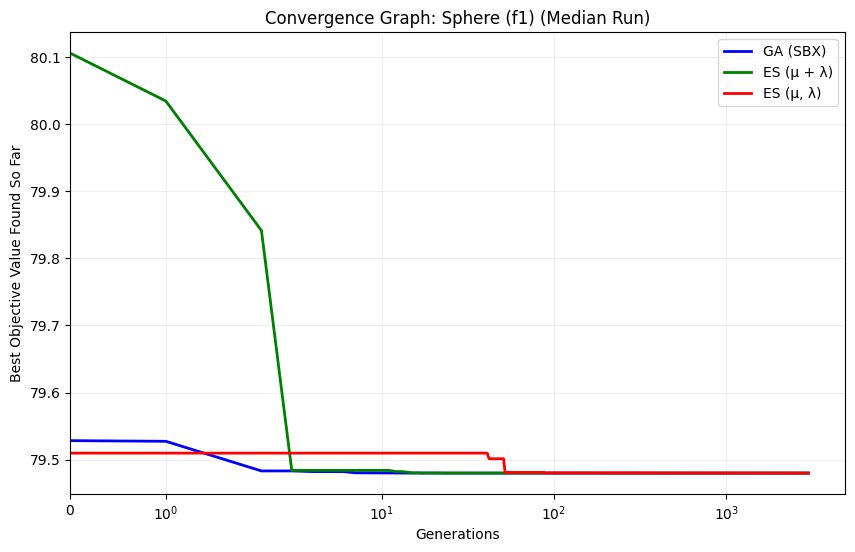

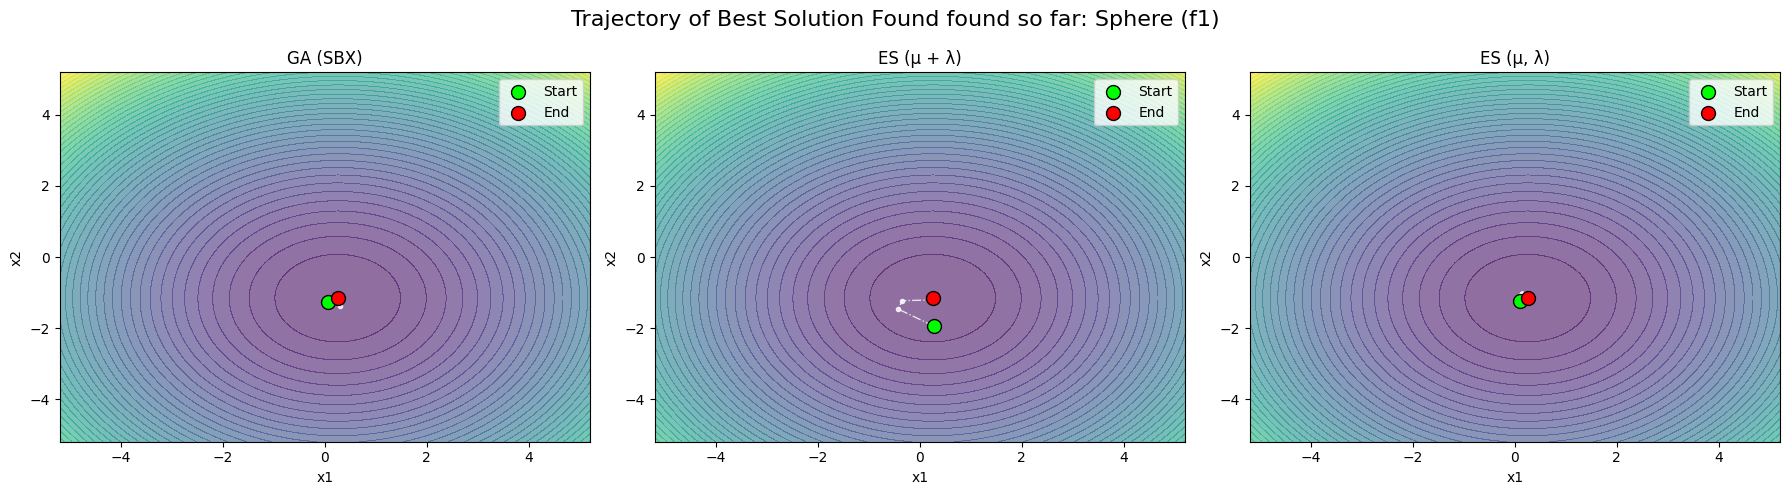

In [47]:
plot_convergence("Sphere (f1)", results_continuous["Sphere (f1)"])

sphere_problem = suite[0]
plot_trajectory("Sphere (f1)", sphere_problem, results_continuous["Sphere (f1)"])

**Rastrigin Separable plots**

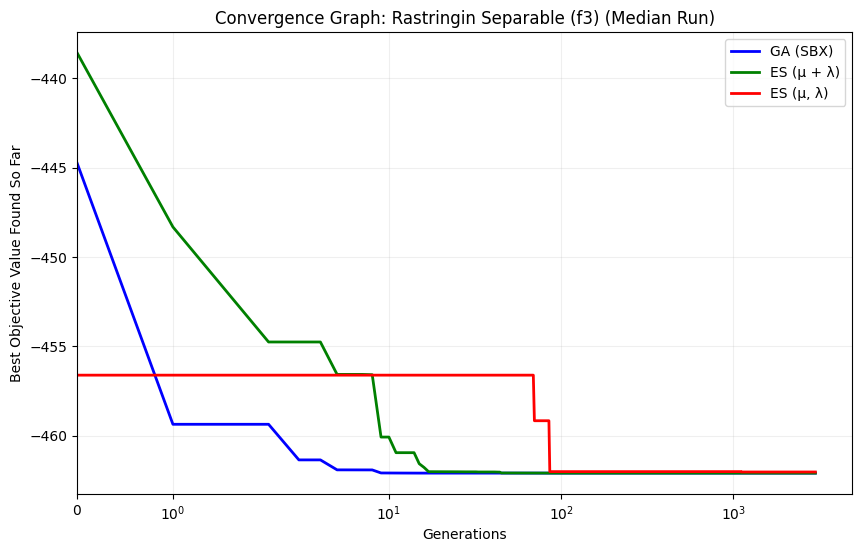

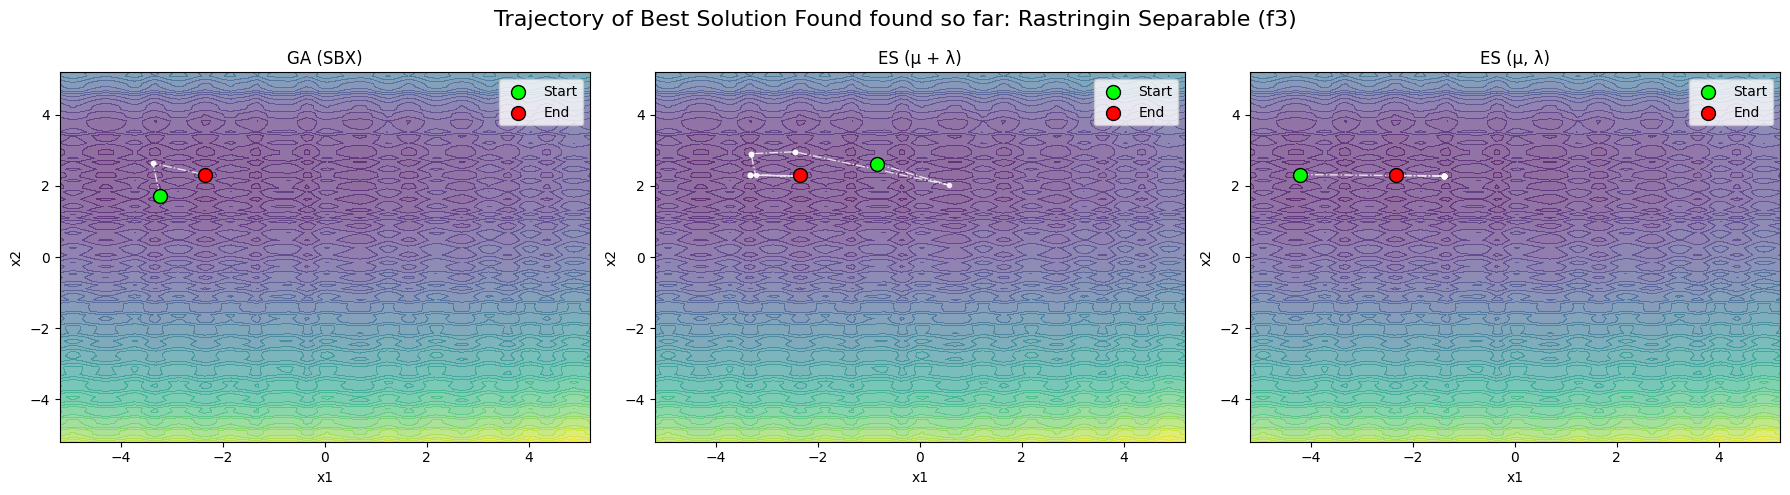

In [48]:
plot_convergence("Rastringin Separable (f3)", results_continuous["Rastringin Separable (f3)"])

rastrigin_separable_problem = suite[1]
plot_trajectory("Rastringin Separable (f3)", rastrigin_separable_problem, results_continuous["Rastringin Separable (f3)"])

**Rosenbrock Rotated plots**

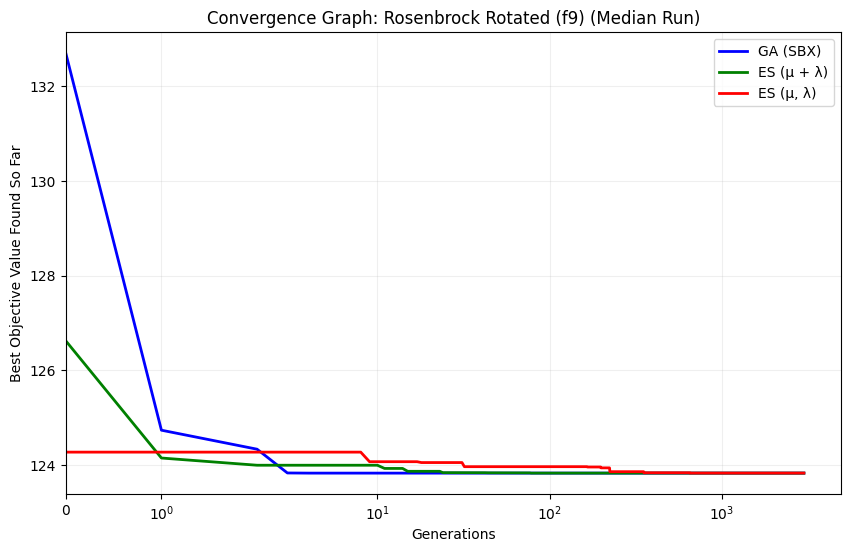

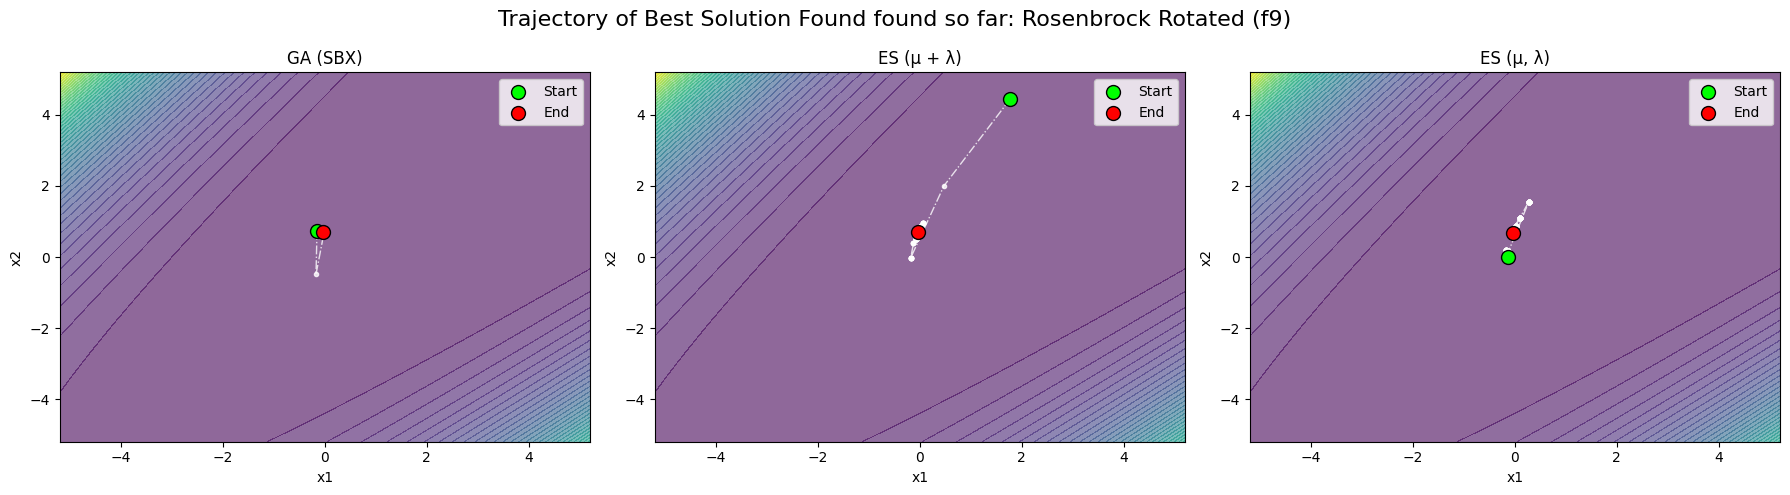

In [49]:
plot_convergence("Rosenbrock Rotated (f9)", results_continuous["Rosenbrock Rotated (f9)"])

rosenbrock_rotated_problem = suite[2]
plot_trajectory("Rosenbrock Rotated (f9)", rosenbrock_rotated_problem, results_continuous["Rosenbrock Rotated (f9)"])

**Weierstrass plots**

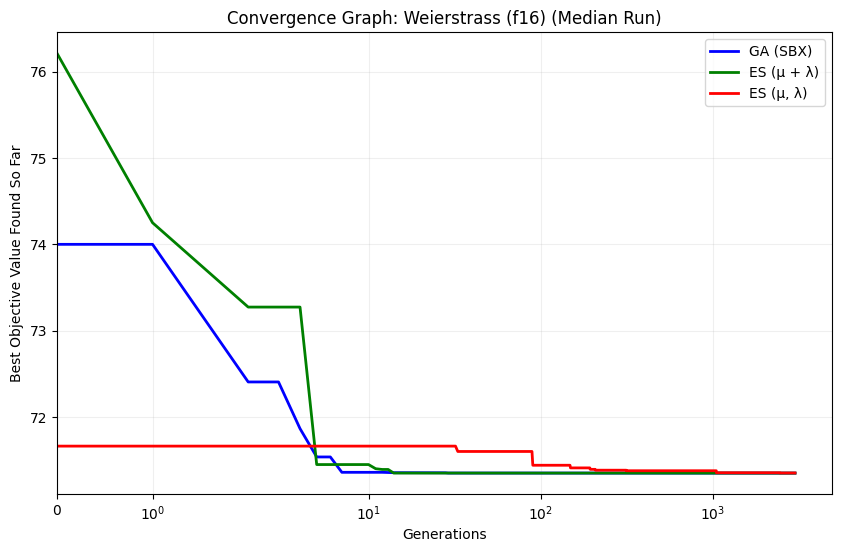

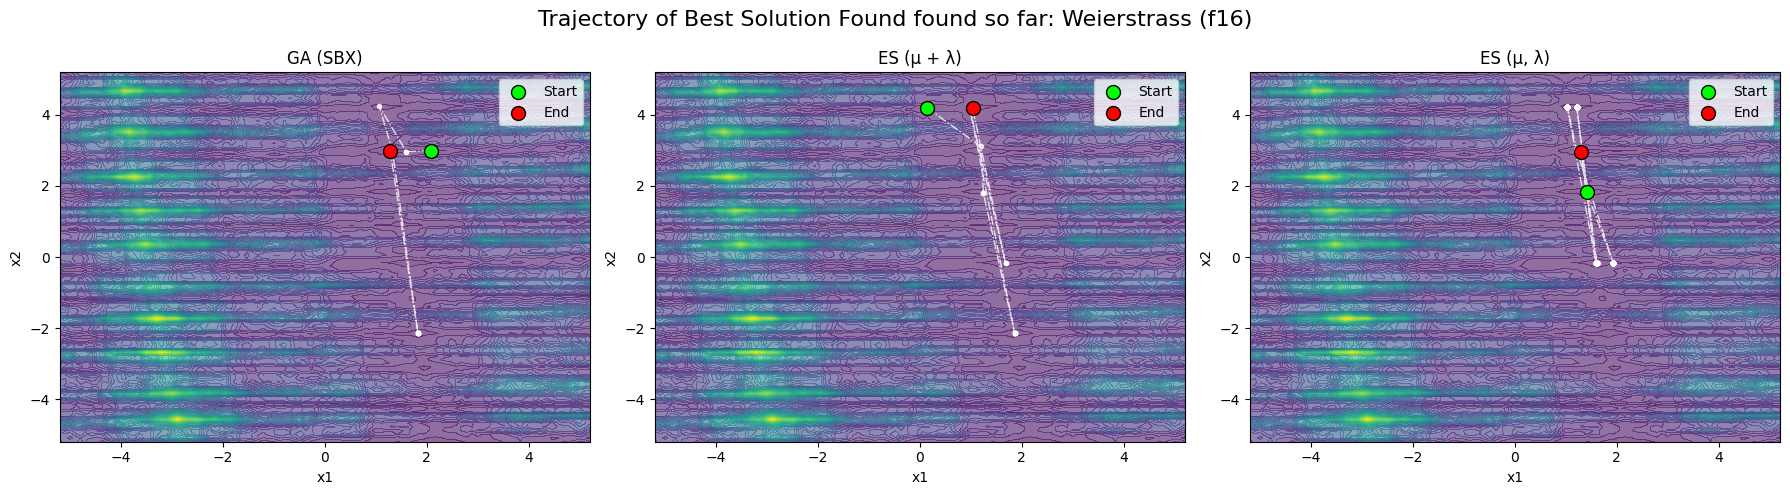

In [50]:
plot_convergence("Weierstrass (f16)", results_continuous["Weierstrass (f16)"])

weierstrass_problem = suite[3]
plot_trajectory("Weierstrass (f16)", weierstrass_problem, results_continuous["Weierstrass (f16)"])

### Discussion of Results
The performance was evaluated across four BBOB continuous optimization problems: Sphere ($f_1$), Rastrigin ($f_3$), Rosenbrock ($f_9$), and Weierstrass ($f_{16}$).

Statistical analysis, supported by the one-tailed Wilcoxon rank-sum test ($\alpha = 0.05$), revealed that the Genetic Algorithm (SBX) was the best performer across the three, achieving statistically significant superiority in three of the four problem instances.

#### Performance

- The experimental data reveals (observed in the convergence plot) that the most significant fitness gains occur within the first 100 generations, followed by a stage where only marginal improvements are recorded before generation 1000. This behavior suggests that the algorithms effectively identify a decent area of attraction early in the search, but struggle with the "micro-adjustment" phase required to reach the high-precision BBOB.

- The $(\mu, \lambda)$-ES (red line in the convergence plots) consistently exhibits the highest degree of stagnation and slower convergence, being the one on all intances that took more generations before obtaining an improvement from the initial (and future) population. This is due to the fact that it does not use elitism; by discarding the parents in every generation, the algorithm lacks a memory of the best-found solution. The convergence plots reflects this behaviour, where a staircase pattern is observed.

- SBX (GA) and $(\mu + \lambda)$-ES both use elitism, which helps preserve the best solutions found so far. This allows them to better explore the local search space around the best solutions, leading to improved convergence behavior compared to the non-elitist $(\mu, \lambda)$-ES.

- Regarding the mutation probability (set at 1/dimension which ends up being 0.5 for the instances used), it is important to note that even though it might be considered numerically high, its potential for disruption is moderated by the sequential nature of the operators. $(\mu + \lambda)$-ES displays this behaviour more evidently on the trajectories plotted.